# 1: Logistic Fish Population Model (Time-Only ODE)

This notebook analyzes single-species fish population growth using the logistic ordinary differential equation.
It compares analytic and numerical solutions, validates their agreement, and generates core diagnostic plots.

## Model

The governing equation is:

\[
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right), \quad r>0, K>0
\]

with initial condition \(x(0)=x_0>0\).

Analytic solution:

\[
x(t) = \frac{K}{1 + \left(\frac{K-x_0}{x_0}\right)e^{-rt}}
\]

Equilibria are \(x^*=0\) and \(x^*=K\). For \(r>0\), \(x^*=0\) is unstable and \(x^*=K\) is stable.


## Quick-Look Plot

This is a minimal first view of logistic growth using only the analytic formula.
It is intentionally independent of the full validation workflow below.


Saved figure: step1_logistic_quick_view.png


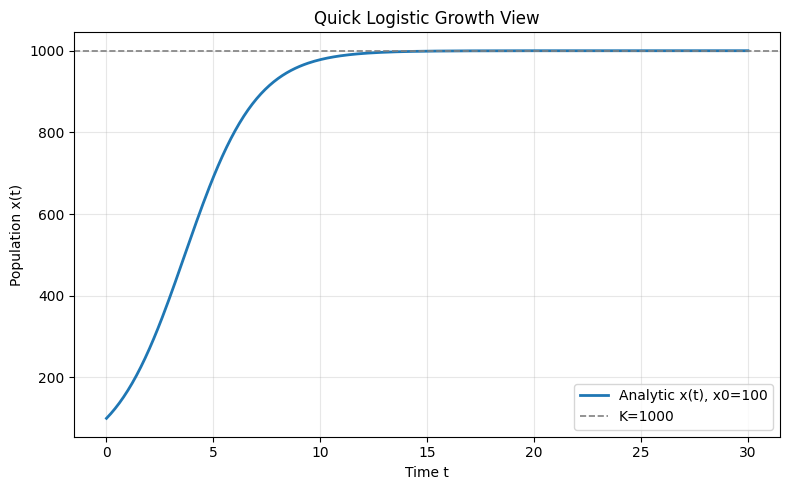

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Quick starter parameters
r_quick: float = 0.6
K_quick: float = 1000.0
x0_quick: float = 100.0
FIG_QUICK: str = "step1_logistic_quick_view.png"

t_quick = np.linspace(0.0, 30.0, 300)
x_quick = K_quick / (1.0 + ((K_quick - x0_quick) / x0_quick) * np.exp(-r_quick * t_quick))

plt.figure(figsize=(8, 5))
plt.plot(t_quick, x_quick, linewidth=2.0, label=f"Analytic x(t), x0={x0_quick:g}")
plt.axhline(K_quick, color="gray", linestyle="--", linewidth=1.2, label=f"K={K_quick:g}")
plt.title("Quick Logistic Growth View")
plt.xlabel("Time t")
plt.ylabel("Population x(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_QUICK, dpi=200)
print(f"Saved figure: {FIG_QUICK}")
plt.show()


## Main Execution

Run the code cell below to:
- print model parameters and equilibrium information,
- validate RK45 against the analytic solution across multiple parameter sets,
- check positivity and report warnings if violations occur,
- save the main figures as PNG files and display them.


In [ ]:
from __future__ import annotations

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp


# -----------------------------
# User-editable model settings
# -----------------------------
T_START: float = 0.0
T_END: float = 30.0
N_POINTS: int = 400
NEGATIVITY_TOL: float = -1e-12

R_MAIN: float = 0.6
K_MAIN: float = 1000.0
X0_LIST: list[float] = [0.1 * K_MAIN, 0.5 * K_MAIN, 1.2 * K_MAIN]

VALIDATION_CASES: list[tuple[float, float, float]] = [
    (0.3, 500.0, 50.0),
    (0.8, 1000.0, 100.0),
    (1.2, 1200.0, 1500.0),
    (0.5, 300.0, 290.0),
]

R_SWEEP: list[float] = [0.2, 0.5, 1.0, 1.5]
X0_SWEEP: float = 0.1 * K_MAIN

FIG_X0_COMPARISON: str = "step1_logistic_x0_comparison.png"
FIG_R_SWEEP: str = "step1_logistic_r_sweep.png"


def logistic_rhs(t: float, x: np.ndarray, r: float, k: float) -> np.ndarray:
    """Return dx/dt for the logistic model."""
    del t  # Autonomous ODE: RHS does not explicitly depend on time.
    return r * x * (1.0 - x / k)


def logistic_analytic(t: np.ndarray, r: float, k: float, x0: float) -> np.ndarray:
    """Closed-form logistic solution for x0 > 0, r > 0, k > 0."""
    if r <= 0.0:
        raise ValueError(f"r must be positive, got {r}")
    if k <= 0.0:
        raise ValueError(f"K must be positive, got {k}")
    if x0 <= 0.0:
        raise ValueError(f"x0 must be positive for analytic formula, got {x0}")

    t_arr = np.asarray(t, dtype=float)
    factor = (k - x0) / x0
    return k / (1.0 + factor * np.exp(-r * t_arr))


def logistic_numeric(t_eval: np.ndarray, r: float, k: float, x0: float) -> np.ndarray:
    """Numerical logistic solution on a provided time grid using RK45."""
    if r <= 0.0:
        raise ValueError(f"r must be positive, got {r}")
    if k <= 0.0:
        raise ValueError(f"K must be positive, got {k}")
    if x0 <= 0.0:
        raise ValueError(f"x0 must be positive, got {x0}")

    t_arr = np.asarray(t_eval, dtype=float)
    if t_arr.ndim != 1 or t_arr.size < 2:
        raise ValueError("t_eval must be a 1D array with at least two points")

    sol = solve_ivp(
        fun=lambda t, y: logistic_rhs(t=t, x=y, r=r, k=k),
        t_span=(float(t_arr[0]), float(t_arr[-1])),
        y0=np.array([x0], dtype=float),
        t_eval=t_arr,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")

    return sol.y[0]


def validate_case(
    r: float,
    k: float,
    x0: float,
    t_eval: np.ndarray,
    negativity_tol: float = NEGATIVITY_TOL,
) -> dict[str, float | bool]:
    """Validate one parameter case and return error/positivity metrics."""
    x_numeric = logistic_numeric(t_eval=t_eval, r=r, k=k, x0=x0)
    x_analytic = logistic_analytic(t=t_eval, r=r, k=k, x0=x0)

    max_abs_error = float(np.max(np.abs(x_numeric - x_analytic)))
    min_numeric = float(np.min(x_numeric))
    min_analytic = float(np.min(x_analytic))

    numeric_negative = bool(np.any(x_numeric < negativity_tol))
    analytic_negative = bool(np.any(x_analytic < negativity_tol))

    return {
        "r": r,
        "K": k,
        "x0": x0,
        "max_abs_error": max_abs_error,
        "min_numeric": min_numeric,
        "min_analytic": min_analytic,
        "numeric_negative": numeric_negative,
        "analytic_negative": analytic_negative,
    }


def print_equilibria_and_stability(k: float) -> None:
    """Print equilibrium points and a brief stability note for r > 0."""
    # For f(x)=r*x*(1-x/K), f'(x)=r*(1-2x/K):
    # at x*=0 -> f'(0)=r>0 (unstable), at x*=K -> f'(K)=-r<0 (stable).
    print(f"Equilibria: x*=0 and x*=K={k:g}")
    print("Stability (r>0): x*=0 is unstable, x*=K is stable.")


def run_validation_suite(
    cases: list[tuple[float, float, float]],
    t_eval: np.ndarray,
    negativity_tol: float,
) -> list[dict[str, float | bool]]:
    """Run validation over multiple (r, K, x0) sets and print diagnostics."""
    print("\nValidation: numeric (RK45) vs analytic")
    print("-" * 56)

    results: list[dict[str, float | bool]] = []
    for idx, (r, k, x0) in enumerate(cases, start=1):
        metrics = validate_case(r=r, k=k, x0=x0, t_eval=t_eval, negativity_tol=negativity_tol)
        results.append(metrics)

        print(
            f"Case {idx}: r={r:.3g}, K={k:.3g}, x0={x0:.3g} -> "
            f"max|x_num-x_an|={metrics['max_abs_error']:.3e}"
        )

        if bool(metrics["numeric_negative"]):
            print(
                "  WARNING: numerical solution went negative "
                f"(min={metrics['min_numeric']:.3e})."
            )
        if bool(metrics["analytic_negative"]):
            print(
                "  WARNING: analytic solution went negative "
                f"(min={metrics['min_analytic']:.3e})."
            )
        if (not bool(metrics["numeric_negative"])) and (not bool(metrics["analytic_negative"])):
            print("  Positivity check passed.")

    worst_error = max(float(item["max_abs_error"]) for item in results)
    print("-" * 56)
    print(f"Worst-case max absolute error across cases: {worst_error:.3e}")
    return results


def plot_initial_condition_comparison(
    t_eval: np.ndarray,
    r: float,
    k: float,
    x0_list: list[float],
    file_name: str,
) -> plt.Figure:
    """Plot x(t) for multiple initial conditions on a single figure."""
    fig, ax = plt.subplots(figsize=(10, 6))

    for x0 in x0_list:
        x_num = logistic_numeric(t_eval=t_eval, r=r, k=k, x0=x0)
        x_an = logistic_analytic(t=t_eval, r=r, k=k, x0=x0)
        ax.plot(t_eval, x_num, linewidth=2.0, label=f"RK45, x0={x0:.1f}")
        ax.plot(t_eval, x_an, "--", linewidth=1.2, label=f"Analytic, x0={x0:.1f}")

    ax.axhline(0.0, color="black", linestyle=":", linewidth=1.2, label="Equilibrium x=0")
    ax.axhline(k, color="gray", linestyle="-.", linewidth=1.2, label=f"Equilibrium x=K={k:g}")

    ax.set_title("Logistic Growth: Multiple Initial Conditions")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Population x(t)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2)

    fig.tight_layout()
    fig.savefig(file_name, dpi=200)
    print(f"Saved figure: {file_name}")
    return fig


def plot_r_sweep(
    t_eval: np.ndarray,
    r_values: list[float],
    k: float,
    x0: float,
    file_name: str,
) -> plt.Figure:
    """Bonus plot: compare growth speed for different intrinsic rates r."""
    fig, ax = plt.subplots(figsize=(10, 6))

    for r in r_values:
        x_num = logistic_numeric(t_eval=t_eval, r=r, k=k, x0=x0)
        ax.plot(t_eval, x_num, linewidth=2.0, label=f"r={r:.2f}")

    ax.axhline(k, color="gray", linestyle="-.", linewidth=1.2, label=f"K={k:g}")
    ax.set_title(f"Logistic Growth Speed for Different r (x0={x0:.1f})")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Population x(t)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    fig.tight_layout()
    fig.savefig(file_name, dpi=200)
    print(f"Saved figure: {file_name}")
    return fig


# -----------------------------
# Main execution
# -----------------------------
t_eval = np.linspace(T_START, T_END, N_POINTS)

print("Logistic Fish Population Model")
print("=" * 56)
print(
    f"Main parameters: r={R_MAIN:g}, K={K_MAIN:g}, "
    f"t in [{T_START:g}, {T_END:g}] with {N_POINTS} points"
)
print(f"Initial conditions for main plot: {', '.join(f'{x0:g}' for x0 in X0_LIST)}")
print_equilibria_and_stability(k=K_MAIN)

_ = run_validation_suite(cases=VALIDATION_CASES, t_eval=t_eval, negativity_tol=NEGATIVITY_TOL)

_ = plot_initial_condition_comparison(
    t_eval=t_eval,
    r=R_MAIN,
    k=K_MAIN,
    x0_list=X0_LIST,
    file_name=FIG_X0_COMPARISON,
)

_ = plot_r_sweep(
    t_eval=t_eval,
    r_values=R_SWEEP,
    k=K_MAIN,
    x0=X0_SWEEP,
    file_name=FIG_R_SWEEP,
)

plt.show()

## 2: Logistic Growth with Fishing (Harvesting)

We now include constant proportional harvesting in the time-only logistic model:

\[
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right) - h x
\]

In [ ]:
# Figure C: Logistic growth with fishing (constant harvesting rate h)
def harvested_rhs(t: float, x: np.ndarray, r: float, K: float, h: float) -> np.ndarray:
    """Right-hand side for harvested logistic growth."""
    del t  # Autonomous ODE.
    return r * x * (1.0 - x / K) - h * x


def harvested_analytic(
    t: np.ndarray,
    x0: float,
    r: float,
    K: float,
    h: float,
):
    """Analytic harvested logistic solution for h < r; otherwise None."""
    if h >= r:
        return None

    t_arr = np.asarray(t, dtype=float)
    a = r - h
    K_eff = K * (1.0 - h / r)
    return K_eff / (1.0 + ((K_eff - x0) / x0) * np.exp(-a * t_arr))


# Required parameters
K_h: float = 1000.0
r_h: float = 0.50
x0_h: float = 500.0
t_h = np.linspace(0.0, 40.0, 801)  # dense time grid
h_values: list[float] = [0.00, 0.10, 0.30, 0.45, 0.55]

fig_c, ax_c = plt.subplots(figsize=(10, 6))

print("\nValidation: RK45 vs analytic (for h < r)")
print("-" * 72)

for h in h_values:
    sol = solve_ivp(
        fun=lambda t, y, h_val=h: harvested_rhs(t=t, x=y, r=r_h, K=K_h, h=h_val),
        t_span=(float(t_h[0]), float(t_h[-1])),
        y0=np.array([x0_h], dtype=float),
        t_eval=t_h,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed for h={h:.2f}: {sol.message}")

    x_num = sol.y[0]
    line, = ax_c.plot(t_h, x_num, linewidth=2.0, label=f"h={h:.2f}")

    if h < r_h:
        x_star = K_h * (1.0 - h / r_h)
        ax_c.axhline(
            x_star,
            color=line.get_color(),
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
            label=f"x* (h={h:.2f})={x_star:.1f}",
        )

        x_an = harvested_analytic(t=t_h, x0=x0_h, r=r_h, K=K_h, h=h)
        max_err = float(np.max(np.abs(x_num - x_an)))
        print(
            f"h={h:.2f}: equilibrium x*={x_star:.3f}, "
            f"max|x_RK45 - x_analytic|={max_err:.3e}"
        )
    else:
        print(
            f"h={h:.2f}: collapse (h >= r). "
            "No positive equilibrium x*; analytic skipped."
        )

ax_c.axhline(K_h, color="gray", linestyle="-.", linewidth=1.2, label=f"K={K_h:g}")
ax_c.set_title("Logistic Growth with Fishing: Effect of Harvest Rate h")
ax_c.set_xlabel("Time t")
ax_c.set_ylabel("Population x(t)")
ax_c.grid(True, alpha=0.3)
ax_c.legend(fontsize=9, ncol=2)
fig_c.tight_layout()
plt.show()

# 3A — Pure Diffusion Sanity Check (Migration Only)

**Purpose:** validate the spatial finite-difference discretisation and Neumann (no-flux) boundary conditions *before* adding logistic growth or fishing.

We solve the pure diffusion PDE on the offshore-distance domain $s \in [0, L]$:

$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial s^2}
$$

with no-flux boundaries:

$$
\frac{\partial u}{\partial s}(0,t) = 0, \qquad \frac{\partial u}{\partial s}(L,t) = 0
$$

**Expected behaviour:**
- The initial Gaussian bump spreads and flattens over time.
- Total mass $M(t) = \int_0^L u(s,t)\,ds$ is conserved (no-flux + no reaction).

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# ── Parameters ───────────────────────────────────────────────────────
L: float = 600.0          # domain length (offshore distance)
N: int = 301              # number of grid points
ds: float = L / (N - 1)   # spatial step

D: float = 10.0           # diffusion coefficient
T_end: float = 20.0       # simulation end time

# Stability-guided time step: dt <= ds^2 / (2D)
dt_max = ds**2 / (2.0 * D)
dt = 0.45 * dt_max
nt = int(np.ceil(T_end / dt))
dt = T_end / nt            # adjust so simulation lands exactly on T_end

s = np.linspace(0.0, L, N)


# ── Helper: Laplacian with Neumann BCs (ghost-point equivalence) ────
def laplacian_neumann(u: np.ndarray, ds: float) -> np.ndarray:
    """Second spatial derivative with no-flux (Neumann) boundaries.

    Ghost-point equivalence gives:
        left  boundary: d²u/ds² ≈ 2*(u[1]  - u[0] ) / ds²
        right boundary: d²u/ds² ≈ 2*(u[-2] - u[-1]) / ds²
    """
    d2u = np.empty_like(u)
    inv_ds2 = 1.0 / ds**2
    # interior points
    d2u[1:-1] = (u[2:] - 2.0 * u[1:-1] + u[:-2]) * inv_ds2
    # boundaries (Neumann via ghost point)
    d2u[0] = 2.0 * (u[1] - u[0]) * inv_ds2
    d2u[-1] = 2.0 * (u[-2] - u[-1]) * inv_ds2
    return d2u


# ── Initial condition: coastal Gaussian bump ─────────────────────────
u = np.exp(-(s / 50.0)**2)

# ── Time integration (explicit Euler) ────────────────────────────────
snapshot_times = {0.0, 5.0, 10.0, 20.0}
snapshots: dict[float, np.ndarray] = {0.0: u.copy()}

mass_history = np.empty(nt + 1)
time_history = np.empty(nt + 1)
mass_history[0] = np.trapz(u, s)
time_history[0] = 0.0

t = 0.0
for n in range(1, nt + 1):
    u = u + dt * D * laplacian_neumann(u, ds)
    t = n * dt
    mass_history[n] = np.trapz(u, s)
    time_history[n] = t
    # capture snapshots (allow small floating-point tolerance)
    for ts in list(snapshot_times):
        if abs(t - ts) < 0.5 * dt:
            snapshots[ts] = u.copy()
            snapshot_times.discard(ts)

# ── Console output ───────────────────────────────────────────────────
print("Pure Diffusion Sanity Check")
print("=" * 56)
print(f"ds = {ds:.4f},  dt = {dt:.6f},  nt = {nt}")
print(f"Initial mass = {mass_history[0]:.10f}")
print(f"Final mass   = {mass_history[-1]:.10f}")
print(f"Mass diff    = {mass_history[-1] - mass_history[0]:.3e}")

# ── Density snapshots ───────────────────────────────────────────────
fig_a, ax_a = plt.subplots(figsize=(10, 6))
for t_snap in sorted(snapshots):
    ax_a.plot(s, snapshots[t_snap], linewidth=2.0, label=f"t = {t_snap:g}")
ax_a.set_title("Pure Diffusion: Density Snapshots")
ax_a.set_xlabel("Offshore distance s")
ax_a.set_ylabel("Population density u(s, t)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()
fig_a.tight_layout()
plt.show()

# ── Mass conservation check ─────────────────────────────────────────
fig_b, ax_b = plt.subplots(figsize=(10, 6))
ax_b.plot(time_history, mass_history, linewidth=2.0)
ax_b.set_title("Pure Diffusion: Mass Conservation Check")
ax_b.set_xlabel("Time t")
ax_b.set_ylabel("Total mass M(t)")
ax_b.grid(True, alpha=0.3)
fig_b.tight_layout()
plt.show()

# 3B — Reaction–Diffusion: Logistic Growth + Migration (No Fishing)

We now combine logistic growth with spatial diffusion:

$$
\frac{\partial u}{\partial t} = r\,u\!\left(1 - \frac{u}{K}\right) + D\,\frac{\partial^2 u}{\partial s^2}
$$

on $s \in [0, L]$ with no-flux (Neumann) boundary conditions, using the same grid and `laplacian_neumann` helper from 3A.

**Two sub-experiments:**
- **(A) Non-uniform IC** — Gaussian bump: observe growth filling the tails toward $K$ while diffusion smooths the profile.
- **(B) Uniform IC validation** — spatially constant $u_0 = 0.2K$: the PDE should reduce to the logistic ODE (no spatial gradients → no diffusion). We overlay the analytic logistic solution to confirm.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# ── Parameters (same grid as 3A) ────────────────────────────────────
L_rd: float = 600.0
N_rd: int = 301
ds_rd: float = L_rd / (N_rd - 1)

D_rd: float = 10.0        # diffusion coefficient (same as 3A)
K_rd: float = 1.0         # carrying capacity (O(1), consistent with Gaussian IC)
r_rd: float = 0.5         # intrinsic growth rate
T_end_rd: float = 60.0    # long enough for convergence to K

# Explicit Euler stability: dt <= ds^2 / (2D)
dt_rd = 0.45 * ds_rd**2 / (2.0 * D_rd)
nt_rd = int(np.ceil(T_end_rd / dt_rd))
dt_rd = T_end_rd / nt_rd  # adjust so we land exactly on T_end

s_rd = np.linspace(0.0, L_rd, N_rd)

print("3B — Reaction–Diffusion (Logistic + Diffusion, No Fishing)")
print("=" * 60)
print(f"ds = {ds_rd:.4f},  dt = {dt_rd:.6f},  nt = {nt_rd}")
print(f"r = {r_rd},  K = {K_rd},  D = {D_rd}")

# =====================================================================
# Part A — Non-uniform IC (Gaussian bump)
# =====================================================================
u_a = np.exp(-(s_rd / 50.0)**2)

snapshot_times_a = {0.0, 10.0, 20.0, 40.0, 60.0}
snapshots_a: dict[float, np.ndarray] = {0.0: u_a.copy()}

t_a = 0.0
for n in range(1, nt_rd + 1):
    lap = laplacian_neumann(u_a, ds_rd)
    u_a = u_a + dt_rd * (r_rd * u_a * (1.0 - u_a / K_rd) + D_rd * lap)
    t_a = n * dt_rd
    for ts in list(snapshot_times_a):
        if abs(t_a - ts) < 0.5 * dt_rd:
            snapshots_a[ts] = u_a.copy()
            snapshot_times_a.discard(ts)

print(f"\nPart A: captured snapshots at t = {sorted(snapshots_a.keys())}")

# ── Plot: Non-uniform IC snapshots ──────────────────────────────────
fig_a, ax_a = plt.subplots(figsize=(10, 6))
for t_snap in sorted(snapshots_a):
    ax_a.plot(s_rd, snapshots_a[t_snap], linewidth=2.0, label=f"t = {t_snap:g}")
ax_a.axhline(K_rd, color="gray", linestyle="--", linewidth=1.2, label=f"K = {K_rd:g}")
ax_a.set_title("Reaction–Diffusion Snapshots (Non-uniform IC)")
ax_a.set_xlabel("Offshore distance s")
ax_a.set_ylabel("Population density u(s, t)")
ax_a.grid(True, alpha=0.3)
ax_a.legend()
fig_a.tight_layout()
plt.show()

# =====================================================================
# Part B — Uniform IC validation
# =====================================================================
u0_uniform = 0.2 * K_rd
u_b = u0_uniform * np.ones(N_rd)

# Track spatial mean and max deviation at each step
mean_history = np.empty(nt_rd + 1)
max_dev_history = np.empty(nt_rd + 1)
time_history_b = np.empty(nt_rd + 1)

mean_history[0] = u_b.mean()
max_dev_history[0] = u_b.max() - u_b.min()
time_history_b[0] = 0.0

for n in range(1, nt_rd + 1):
    lap = laplacian_neumann(u_b, ds_rd)
    u_b = u_b + dt_rd * (r_rd * u_b * (1.0 - u_b / K_rd) + D_rd * lap)
    time_history_b[n] = n * dt_rd
    mean_history[n] = u_b.mean()
    max_dev_history[n] = u_b.max() - u_b.min()

# Analytic logistic ODE solution (reuse from section 1)
u_analytic = logistic_analytic(time_history_b, r=r_rd, k=K_rd, x0=u0_uniform)

worst_spatial_dev = max_dev_history.max()
mean_error = float(np.max(np.abs(mean_history - u_analytic)))

print(f"\nPart B — Uniform IC validation (u0 = {u0_uniform})")
print(f"Max spatial deviation over entire run: {worst_spatial_dev:.3e}")
print(f"Max |PDE mean - analytic ODE|:         {mean_error:.3e}")

# ── Plot: Uniform IC validation ─────────────────────────────────────
fig_b, ax_b = plt.subplots(figsize=(10, 6))
ax_b.plot(time_history_b, u_analytic, linewidth=2.0, label="Logistic ODE (analytic)")
ax_b.plot(time_history_b, mean_history, "--", linewidth=1.2, label="PDE spatial mean")
ax_b.axhline(K_rd, color="gray", linestyle="-.", linewidth=1.2, label=f"K = {K_rd:g}")
ax_b.set_title("Uniform IC Validation: PDE vs Logistic ODE")
ax_b.set_xlabel("Time t")
ax_b.set_ylabel("Population density u")
ax_b.grid(True, alpha=0.3)
ax_b.legend()
fig_b.tight_layout()
plt.show()